<a href="https://colab.research.google.com/github/lkarjun/fastai-workouts/blob/master/Lesson_11_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# from fastai.vision.all import *
# import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
# Correct Path
from fastai.vision.core import fastuple, PILImage
from fastai.vision.data import get_image_files
from fastai.data.external import untar_data, URLs
import fastai; fastai.__version__

'2.5.3'

In [10]:
path = untar_data(URLs.PETS)

In [11]:
files = get_image_files(path/"images")

## Siamese Pair

In [23]:
from fastai.torch_basics import Tensor, tensor, torch
from fastai.vision.core import show_image
from fastai.vision.augment import Resize
from fastai.vision.data import Transform

from fastai.vision.all import *

In [8]:
class SiameseImage(fastuple):
  def show(self, ctx=None, **kwargs):
    img1, img2, same_or_not = self
    if not isinstance(img1, Tensor):
      if img2.size != img1.size:
        img2 = img2.resize(img1.size)
      t1, t2 = tensor(img1), tensor(img2)
    else: t1, t2 = img1, img2
    line = t1.new_zeros(t1.shape[0], 20, t1.shape[2])
    return show_image(torch.cat([t1,line,t2], dim=1),
                          title=same_or_not, ctx=ctx)

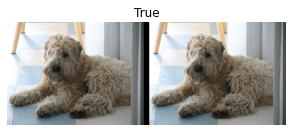

In [12]:
img = PILImage.create(files[0])
s = SiameseImage(img, img, True)
s.show()

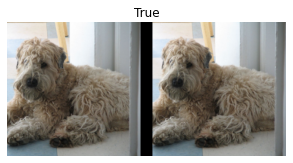

In [18]:
s2 = Resize(224)(s)
s2.show()

In [20]:
import re

In [38]:
def label_func(fname):
  match = re.match(r'^(.*)_\d+.jpg$', fname.name).groups()[0]
  return match

In [102]:
class SiameseTransform(Transform):
  def __init__(self, files, label_func, splits):
    self.labels = files.map(label_func).unique()

    self.lbl2files = {class_name: L(f for f in files if label_func(f) == class_name)
                        for class_name in self.labels}

    self.label_func = label_func
    self.valid = {f: self._draw(f) for f in files[splits[1]]}

  def encodes(self, f):
    f2, t = self.valid.get(f, self._draw(f))
    img1, img2 = PILImage.create(f), PILImage.create(f2)
    return SiameseImage(img1, img2, t)

  def _draw(self, f):
    same = random.random() < .5
    cls = self.label_func(f)
    if not same:
      cls = random.choice(L(l for l in self.labels if l != cls))
    return random.choice(self.lbl2files[cls]), same

In [103]:
splits = RandomSplitter()(files)
tfm = SiameseTransform(files, label_func, splits)

In the mid-level API for data collection we have two objects that can help us apply transforms on a set of items, TfmdLists and Datasets. If you remember what we have just seen, one applies a Pipeline of transforms and the other applies several Pipelines of transforms in parallel, to build tuples. Here, our main transform already builds the tuples, so we use TfmdLists:



In [107]:
tls = TfmdLists(files, SiameseTransform(files, label_func, splits), splits=splits)

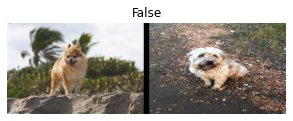

In [110]:
show_at(tls.valid, 0)

We can finally get our data in DataLoaders by calling the dataloaders method. One thing to be careful of here is that this method does not take item_tfms and batch_tfms like a DataBlock. The fastai DataLoader has several hooks that are named after events; here what we apply on the items after they are grabbed is called after_item, and what we apply on the batch once it's built is called after_batch:

In [116]:
dls = tls.dataloaders(bs=10, 
                      after_item=[Resize(224), ToTensor],
                      after_batch = [IntToFloatTensor, Normalize.from_stats(*imagenet_stats)]
                      )

In [120]:
a = dls.one_batch()

In [131]:
a[0].shape, a[1].shape, a[2].shape

(torch.Size([10, 3, 224, 224]),
 torch.Size([10, 3, 224, 224]),
 torch.Size([10]))